# load numerical model (Anne M) and inspect

In [1]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import xarray as xr
import xgcm

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo

# cognac data and tools
#import cognac.insitu as iu
#import pynsitu as pin

In [2]:
def plot_map(da, das, figsize=(10,7), **kwargs):
    """ utility method for maps"""

    #fig, ax = plt.subplots(1,1)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=ccrs.Orthographic(6, 43.))

    da.plot(x="lon", y="lat", ax=ax, transform=ccrs.PlateCarree(), **kwargs)
    ax.set_extent([5.2, 6.7, 42.7, 43.4])

    gl = ax.gridlines(draw_labels=True, dms=False,
                      x_inline=False, y_inline=False,
                    )
    gl.right_labels=False
    gl.top_labels=False    
    
    #dland = dict(scale="110m", edgecolor='face', facecolor=cfeature.COLORS['land'])
    #land_feature = cfeature.NaturalEarthFeature('physical', 'land', **dland)
    #ax.add_feature(land_feature,  zorder=0)
    ax.coastlines(resolution='10m', color="k", linestyle='-', alpha=1)
    
    ax.plot(das.longitude, das.latitude, color="0.8", lw=3, transform=ccrs.PlateCarree(),)

    da.h.plot.contour(x="lon", y="lat", levels=[100], colors="w", linestyles="--",
                      transform=ccrs.PlateCarree())
    
    return fig

----

## load data

To be done on datarmor.
Copy extracted netcdf file back on laptop.

In [3]:
root_dir = "/home/datawork-lops-osi/equinox/das"

In [4]:
# load das coordinates
nc = os.path.join(root_dir, "common/coords_toulon.nc")
das = xr.open_dataset(nc)

In [5]:
# load model grid
grid_nc = os.path.join(root_dir, "model_mio/gridT.nc")
grid = xr.open_dataset(grid_nc)
grid = grid.rename(**{"X200_299": "x", "Y110_179": "y", "Z":"depth",
                      "MBATHY": "bottom", "NAV_LON": "lon", "NAV_LAT": "lat",
                     } )
grid = (grid
        .set_index(depth="NAV_LEV")
        .set_coords(["lon", "lat"])
        .squeeze()
       )
grid = grid.assign_coords(h=grid.depth.isel(depth=grid.bottom).drop("depth"))

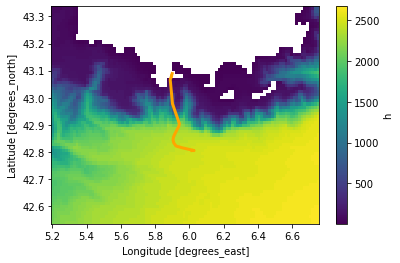

In [6]:
fig, ax = plt.subplots(1,1)
grid.h.where(grid.h>1).plot(x="lon", y="lat")
ax.plot(das.longitude, das.latitude, color="orange", lw=3)

In [7]:
# load data
def preprocess(ds):
    ds = ds.rename(**{"X200_299": "x", "Y110_179": "y", "DEPTHT":"depth",
                      "TIME_COUNTER": "time", 
                      "DEPTHT_bnds": "z_bounds",
                      "VOTEMPER": "temperature",
                     } 
                  )
    return ds
    
nc_files = sorted(glob(os.path.join(root_dir, "model_mio/Temp_*.nc")))
ds = xr.open_mfdataset(nc_files, preprocess=preprocess, concat_dim="time", combine="nested")
ds = ds.assign_coords(**grid)

# bottom
ds["temperature_bottom"] = ds.temperature.isel(depth=ds.bottom-1)
ds["temperature_bottom_mean"] = ds["temperature_bottom"].mean("time")
ds["temperature_bottom_anomaly"] = (ds.temperature_bottom - ds.temperature_bottom_mean).compute()

dsm = ds.mean("time").compute()

In [8]:
print(f"simulation starts on "+ds.time[0].dt.strftime("%Y/%m/%d %H:%M").values)
print(f"simulation ends on "+ds.time[-1].dt.strftime("%Y/%m/%d %H:%M").values)

delta_t = float((ds.time[-1] - ds.time[0])/pd.Timedelta("1D"))
print(f"simulation length = {delta_t:.1f} days" )

simulation starts on 2019/07/14 00:30
simulation ends on 2019/07/31 23:30
simulation length = 18.0 days


----

## mean thermal stratification

In [9]:
dsm["dTdz"] = - dsm.temperature.mean(["x", "y"]).differentiate("depth")

(1000.0, 0.0)

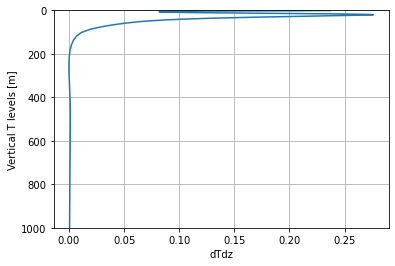

In [10]:
fig, ax = plt.subplots(1,1)
dsm["dTdz"].plot(y="depth")
ax.grid()
#ax.invert_yaxis()
ax.set_ylim(1000,0)

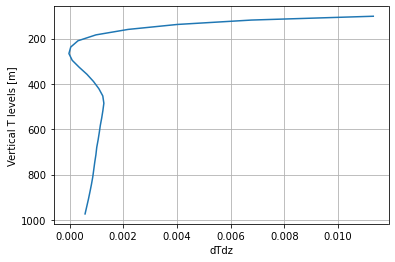

In [11]:
fig, ax = plt.subplots(1,1)
dsm["dTdz"].sel(depth=slice(100, 1000)).plot(y="depth")
ax.grid()
ax.invert_yaxis()
#ax.set_ylim(1000,200)

---

## maps

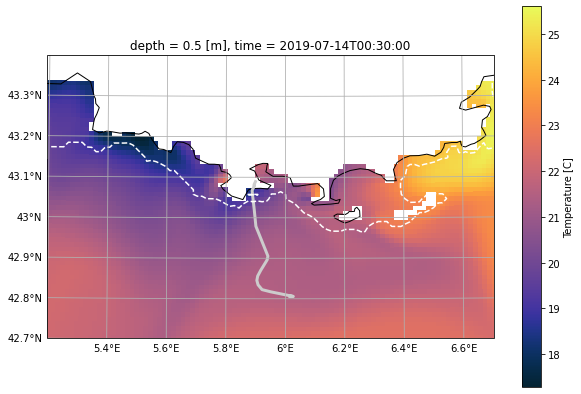

In [15]:
# surface
da = ds.temperature.isel(depth=0).isel(time=0)
plot_map(da, das, cmap=cm.thermal, extend="neither");

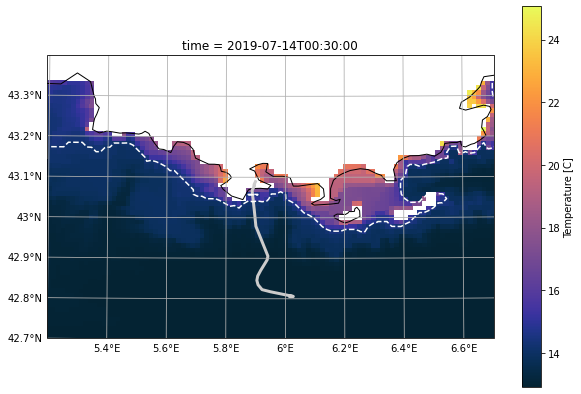

In [16]:
# bottom
da = ds.temperature_bottom.isel(time=0)
plot_map(da, das, cmap=cm.thermal, extend="neither");

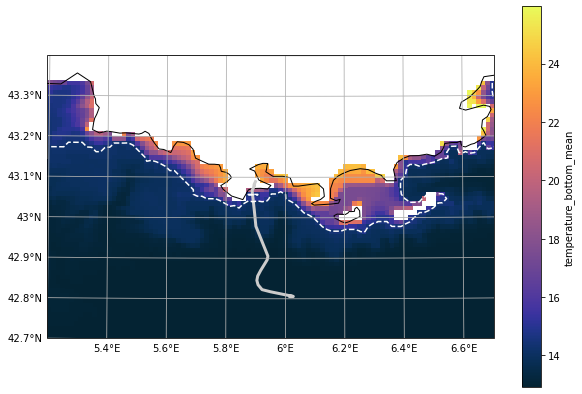

In [17]:
# bottom: mean
da = ds.temperature_bottom_mean
plot_map(da, das, cmap=cm.thermal, extend="neither");

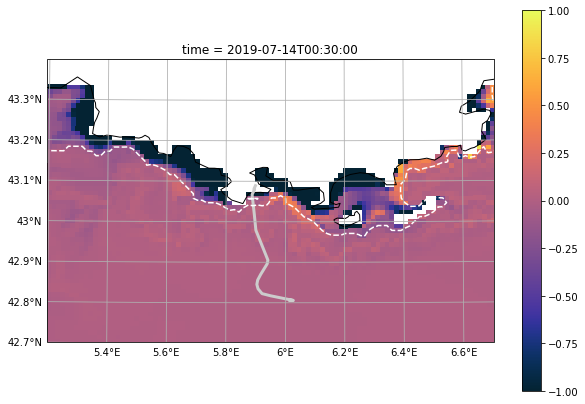

In [18]:
# bottom anomaly
da = (ds.temperature_bottom.isel(time=0) - ds.temperature_bottom_mean)
plot_map(da, das, vmin=-1, vmax=1, cmap=cm.thermal, extend="neither");

### make movie

In [44]:
plt.switch_backend("agg")

i=0
for t in tqdm(da.time):
    _da = da.sel(time=t)
    fig = plot_map(_da, das, vmin=-1, vmax=1, cmap=cm.thermal, extend="neither")
    savefig = os.path.join(os.environ["SCRATCH"], f"figs/mio_{i:03d}.png")
    fig.savefig(savefig, dpi=150, bbox_inches = "tight", facecolor='white', transparent=False)
    plt.close(fig)
    i+=1


100%|██████████| 432/432 [03:53<00:00,  1.85it/s]


### plot temperature bottom standard deviation

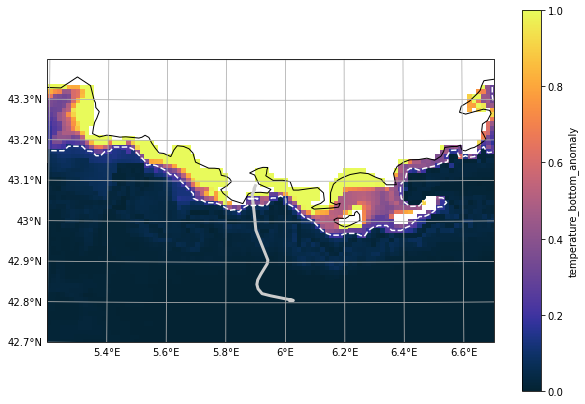

In [19]:
da = ds["temperature_bottom_anomaly"].std("time")
plot_map(da, das, vmin=0, vmax=1, cmap=cm.thermal, extend="neither");

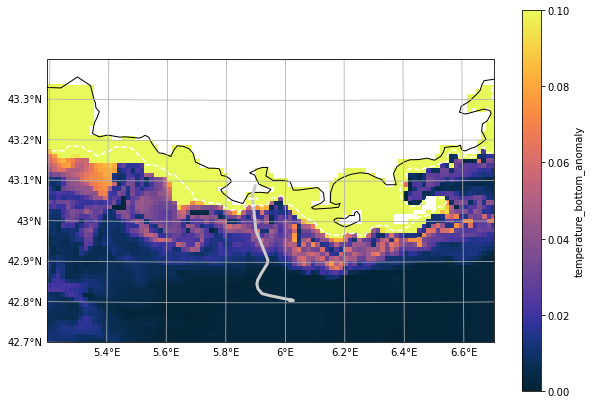

In [20]:
plot_map(da, das, vmin=0, vmax=.1, cmap=cm.thermal, extend="neither");

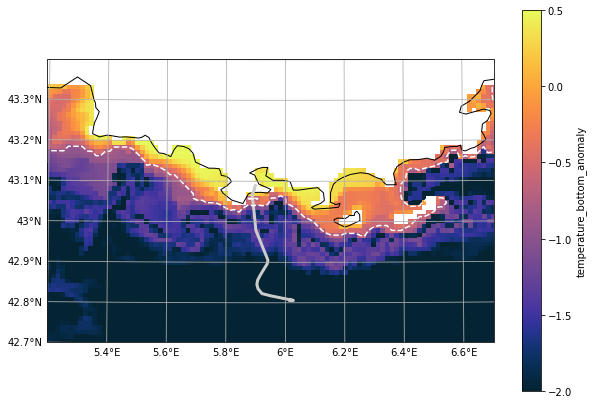

In [21]:
da = np.log10(ds["temperature_bottom_anomaly"].std("time"))
plot_map(da, das, vmin=-2, vmax=0.5, cmap=cm.thermal, extend="neither");

---
## create DAS like signal

In [14]:
import xesmf as xe

In [23]:
# interpolate data along cable position
_das = das.rename(longitude="lon", latitude="lat")
regridder = xe.Regridder(ds, _das, "bilinear", locstream_out=True)
ds_at_das = regridder(ds)
ds_at_das = ds_at_das.drop("depth").assign_coords(depth=das.depth)

In [59]:
ds_at_das

<xarray.Dataset>
Dimensions:                     (time: 432, depth: 130, channel: 4480)
Coordinates:
  * time                        (time) datetime64[ns] 2019-07-14T00:30:00 ......
    depth                       (channel) float64 0.0 0.0 ... 2.393e+03
Dimensions without coordinates: channel
Data variables:
    temperature                 (time, depth, channel) float32 dask.array<chunksize=(72, 130, 4480), meta=np.ndarray>
    temperature_bottom          (time, channel) float32 dask.array<chunksize=(72, 4480), meta=np.ndarray>
    temperature_bottom_mean     (channel) float32 dask.array<chunksize=(4480,), meta=np.ndarray>
    temperature_bottom_anomaly  (time, channel) float32 nan nan ... -0.001121
Attributes:
    regrid_method:  bilinear

In [63]:
def plot_das(da, figsize=(10,5), **kwargs):

    gs_kw = dict(width_ratios=[.3, 1])
    fig, axd = plt.subplot_mosaic([['left', 'right']],
                                  gridspec_kw=gs_kw, figsize=figsize,
                                  constrained_layout=True, sharey=True)
    print(axd)
    # bathy
    ax = axd["left"]
    da.depth.plot(y="channel", ax=ax)
    ax.grid()
    #ax.invert_yaxis()
    
    #fig, ax = plt.subplots(1,1, figsize=figsize)
    ax = axd["right"]    
    da.plot(x="time", ax=ax, **kwargs)
    ax.grid()
    ax.invert_yaxis()
    
    return ax

{'left': <AxesSubplot:label='left'>, 'right': <AxesSubplot:label='right'>}


Text(0.5, 1.0, 'Temperature along cable')

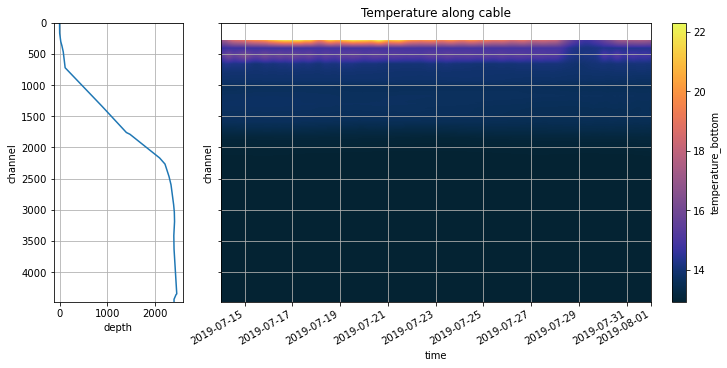

In [64]:
da = ds_at_das["temperature_bottom"]
ax=plot_das(da, cmap=cm.thermal)
ax.set_title("Temperature along cable")

{'left': <AxesSubplot:label='left'>, 'right': <AxesSubplot:label='right'>}


Text(0.5, 1.0, 'Temperature anomaly along cable')

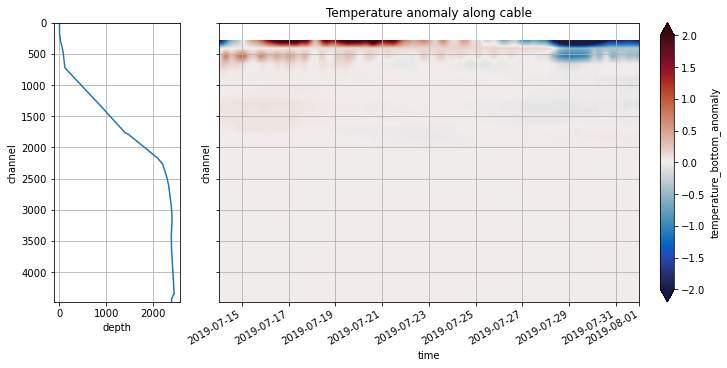

In [65]:
da = ds_at_das["temperature_bottom_anomaly"]
ax=plot_das(da, vmax=2., cmap=cm.balance)
ax.set_title("Temperature anomaly along cable")

{'left': <AxesSubplot:label='left'>, 'right': <AxesSubplot:label='right'>}


Text(0.5, 1.0, 'Temperature anomaly along cable')

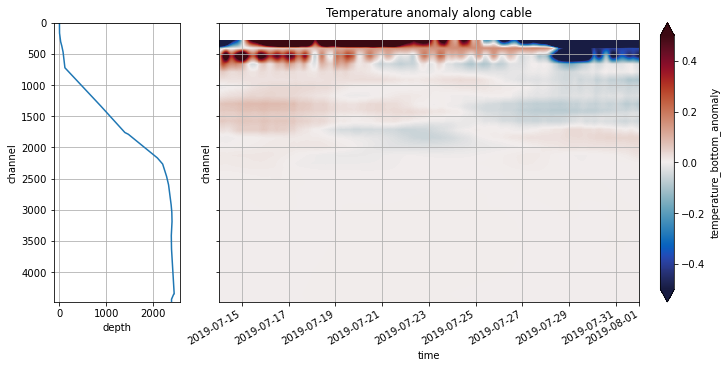

In [66]:
da = ds_at_das["temperature_bottom_anomaly"]
ax=plot_das(da, vmax=.5, cmap=cm.balance)
ax.set_title("Temperature anomaly along cable")

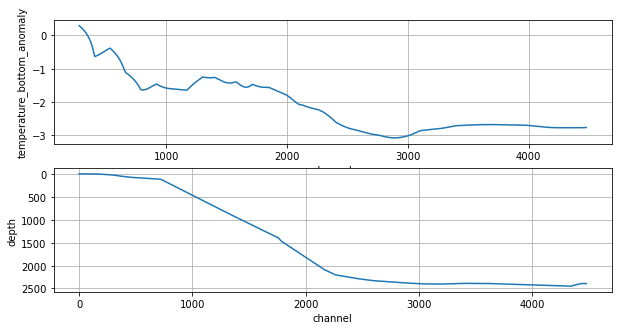

In [74]:
fig, axes = plt.subplots(2,1,figsize=(10,5))

ax = axes[0]
da = ds_at_das.temperature_bottom_anomaly.std("time")
da = np.log10(da)
da.plot(ax=ax)
ax.grid()

ax = axes[1]
ds_at_das.depth.plot(ax=ax)
ax.grid()
ax.invert_yaxis()

In [ ]:
Should add vertical gradient as well

---

## rapide overview over straight transect

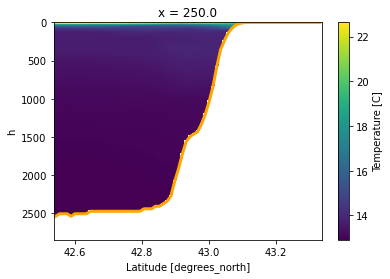

In [20]:
da = ds.temperature.isel(x=50)

fig, ax = plt.subplots(1,1)
da.isel(time=0).plot(x="lat", y="depth", ax=ax)

da.h.plot(x="lat", color="orange", lw=3)

ax.invert_yaxis()

In [ ]:
_da = da.isel(depth=da.bottom-1)

_da.plot(x="time")

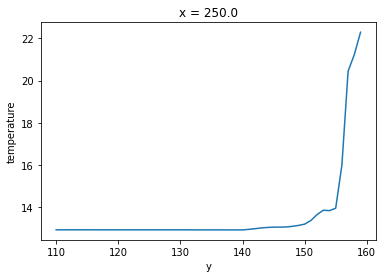

In [114]:
_da.mean("time").plot()

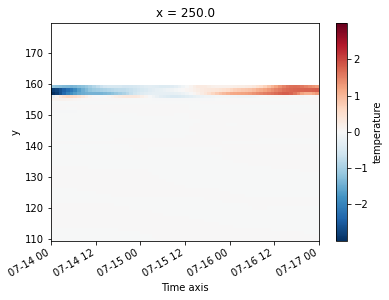

In [113]:
(_da-_da.mean("time")).plot(x="time")

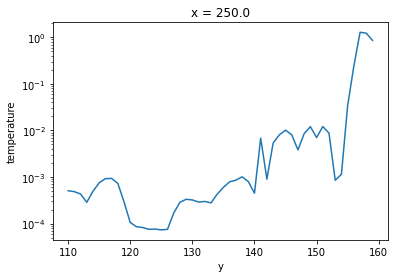

In [117]:
(_da-_da.mean("time")).std("time").plot(yscale="log")

### store data